<a href="https://colab.research.google.com/github/JayantMiglani/TweetEmotionRecognition/blob/main/TweetEmotionRecognitionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 212 kB 49.7 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset= nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']


In [6]:
def get_tweet(data):
  tweets= [x['text'] for x in data] ## reference iterator x
  labels=[x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels= get_tweet(train)

In [8]:
tweets[100], labels[100]

('i wont let me child cry it out because i feel that loving her and lily when she was little was going to be opportunities that only lasted for those short few months',
 'love')

## Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)##tweets from training set--> we get a corresponding tokenizer vector

In [11]:
## what didi the tokenization process actually do?
tokenizer.texts_to_sequences([tweets[0], tweets[1]])
## instead of the words we actually see the tokenizer vector<vector<int>>, here which corresponds to jst the first tweet passed

[[2, 139, 3, 679],
 [2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

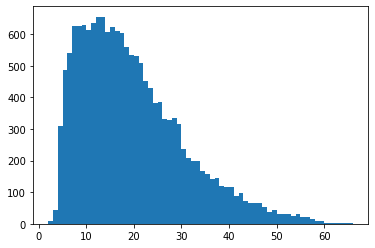

In [12]:
lengths= [len(t.split(' '))for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [13]:
maxlen= 50
## to help with padding->
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer, tweets):
  sequences= tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating= 'post', padding= 'post', maxlen=50)
  return padded

In [15]:
padded_train_seq= get_sequences(tokenizer, tweets)

In [16]:
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [17]:
classes= set(labels)
print(classes)

{'anger', 'joy', 'love', 'surprise', 'fear', 'sadness'}


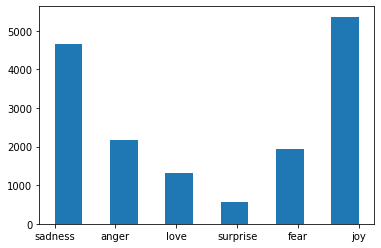

In [18]:
plt.hist(labels,bins=11)
plt.show()
## since the number of labels corresponding to each class spans such a huge range, we have a class impbalance problem
## these problems can be vaoided

In [19]:
class_to_index= dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())


In [20]:
class_to_index

{'anger': 0, 'fear': 4, 'joy': 1, 'love': 2, 'sadness': 5, 'surprise': 3}

In [21]:
index_to_class

{0: 'anger', 1: 'joy', 2: 'love', 3: 'surprise', 4: 'fear', 5: 'sadness'}

In [22]:
names_to_ids= lambda labels: np.array([class_to_index.get(x) for x in labels])

In [23]:
train_labels= names_to_ids(labels)
print(train_labels[0])

5


## Creating the Model

1. Creating the model
2. Compiling the model

In [24]:
model= tf.keras.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    ##lstm layer 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences= True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation= 'softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [26]:
val_tweets, val_labels= get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels= names_to_ids(val_labels)

In [27]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [28]:
## just train the model now
h= model.fit(
    padded_train_seq, train_labels,
    validation_data= (val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 41s 60ms/step - loss: 1.3310 - accuracy: 0.4744 - val_loss: 0.8338 - val_accuracy: 0.6960
Epoch 2/20
500/500 [==============================] - 28s 55ms/step - loss: 0.5618 - accuracy: 0.7998 - val_loss: 0.5251 - val_accuracy: 0.8265
Epoch 3/20
500/500 [==============================] - 28s 56ms/step - loss: 0.3255 - accuracy: 0.8941 - val_loss: 0.4681 - val_accuracy: 0.8460
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.2398 - accuracy: 0.9228 - val_loss: 0.4205 - val_accuracy: 0.8635
Epoch 5/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1746 - accuracy: 0.9421 - val_loss: 0.4778 - val_accuracy: 0.8655
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1419 - accuracy: 0.9513 - val_loss: 0.4050 - val_accuracy: 0.8745
Epoch 7/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1180 - accuracy: 0.9619 - val_loss: 0.4243 - val_accuracy:

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

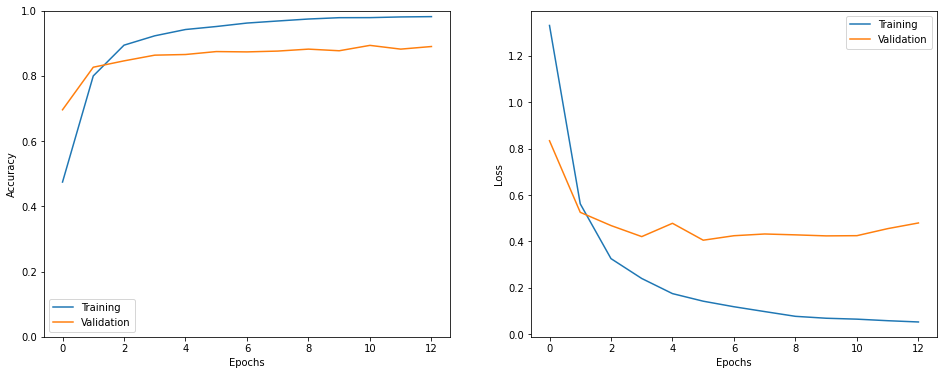

In [29]:
show_history(h)

In [30]:
test_tweets,test_labels= get_tweet(test)
test_seq= get_sequences(tokenizer, test_tweets)
test_labels= names_to_ids(test_labels)

In [31]:
_= model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4682 - accuracy: 0.8985


In [32]:
preds=model.predict(test_seq) 
preds= np.argmax(preds,axis=-1)

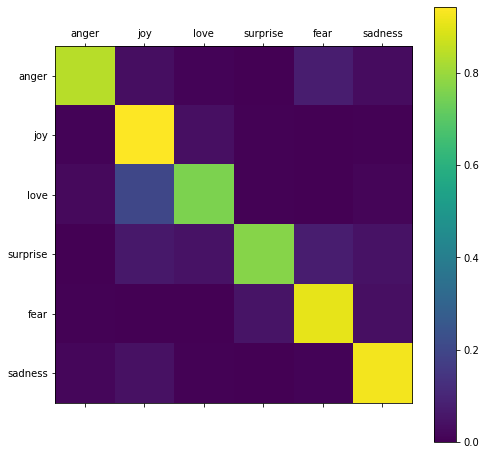

In [33]:
show_confusion_matrix(test_labels, preds, list(classes))